In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

def draw(X):
    '''
    描画を行う関数
    
    '''
    plt.figure(figsize=(8, 8)) # 描画エリアは8×8インチ
    pos = 1                    # 画像の描画位置を保持
    # 画像の枚数だけ描画処理を繰り返す
    for i in range(X.shape[0]):
        plt.subplot(4, 4, pos) # 4×4の描画領域のpos番目の位置
        plt.imshow(X[i])       # インデックスiの画像を描画
        plt.axis('off')        # 軸目盛は非表示
        pos += 1
    plt.show()

In [40]:
from keras.datasets import mnist
# CIFAR-10データを読み込む
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
# データのピクセル値を0～1の範囲にに変換
X_train /= 255.0

# テストで使用する画像の枚数
batch_size = 16

In [41]:
# オリジナルの画像を表示
#draw(X_train[0:batch_size])
np.save('./MNIST.npz',X_train[50000:batch_size])

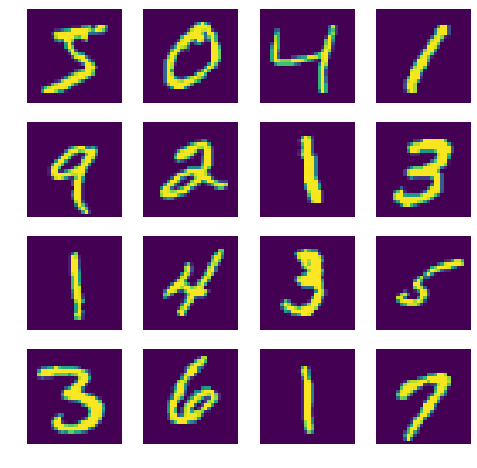

In [42]:
# ImageDataGeneratorのインポート
from keras.preprocessing.image import ImageDataGenerator
# 平行移動　最大0.5
X_train = X_train.reshape(60000,28,28,1)
datagen = ImageDataGenerator(width_shift_range=0, zoom_range=0)
g = datagen.flow(           # 拡張データを作成
    X_train, y_train, batch_size, shuffle=False)
X_batch, y_batch = g.next() # 拡張データをリストに格納
X_batch = X_batch.reshape(16,28,28)
draw(X_batch)               # 描画

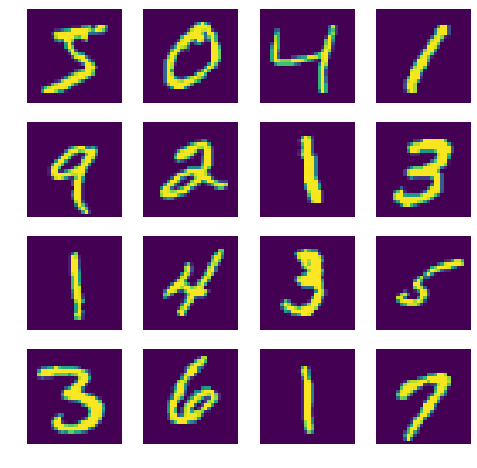

In [43]:
# 垂直移動　最大0.5
datagen = ImageDataGenerator(height_shift_range=0,zoom_range=0)
g = datagen.flow(           # 拡張データを作成
    X_train, y_train, batch_size, shuffle=False)
X_batch, y_batch = g.next() # 拡張データをリストに格納
X_batch = X_batch.reshape(16,28,28)
draw(X_batch)               # 描画

In [44]:
# 学習用データを水増しする --- (*1)
x_new = []
y_new = []
for i, xi in enumerate(X_train):
    yi = y_train[i]
    for ang in range(-5, 5, 10):
        # 回転させる --- (*2)
        center = (14, 14) # 回転の中心点
        mtx = cv2.getRotationMatrix2D(center, ang, 1.5)
        xi2 = cv2.warpAffine(xi, mtx, (28, 28))
        x_new.append(xi2)
        y_new.append(yi)
        '''# さらに左右反転させる --- (*3)
        xi3 = cv2.flip(xi2, 1)
        x_new.append(xi3)
        y_new.append(yi)'''        
        
# 水増しした画像を学習用に置き換える
print('水増し前=', len(y_train))
X_train = np.array(x_new)
y_train = np.array(y_new)
print('水増し後=', len(y_train))


水増し前= 60000
水増し後= 60000


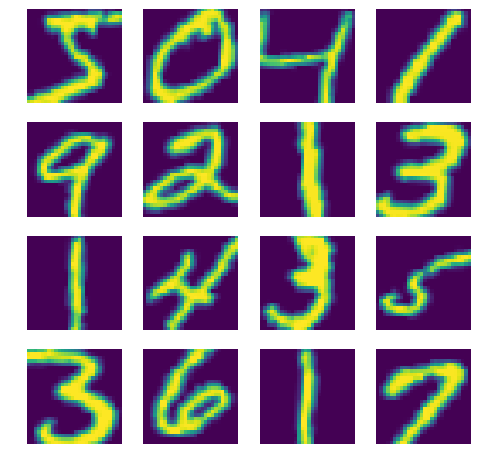

In [45]:
# ImageDataGeneratorのインポート
from keras.preprocessing.image import ImageDataGenerator
# 平行移動　最大0.5
X_train = X_train.reshape(60000,28,28,1)
datagen = ImageDataGenerator(width_shift_range=0, zoom_range=0)
g = datagen.flow(           # 拡張データを作成
    X_train, y_train, batch_size, shuffle=False)
X_batch, y_batch = g.next() # 拡張データをリストに格納
X_batch = X_batch.reshape(16,28,28)
draw(X_batch)               # 描画

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2479 - acc: 0.9235 - val_loss: 0.1090 - val_acc: 0.9659
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.1030 - acc: 0.9684 - val_loss: 0.0818 - val_acc: 0.9733
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0759 - acc: 0.9764 - val_loss: 0.0632 - val_acc: 0.9799
Epoch 4/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0606 - acc: 0.9817 - val_loss: 0.0685 - val_acc: 0.9814
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0499 - acc: 0.9852 - val_loss: 0.0646 - val_acc: 0.9827
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0420 - acc: 0.9870 - val_loss: 0.0659 - val_acc: 0.9833
Epoch 7/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.0394 - acc: 0.9886 - val_loss: 0.0714 - val_acc

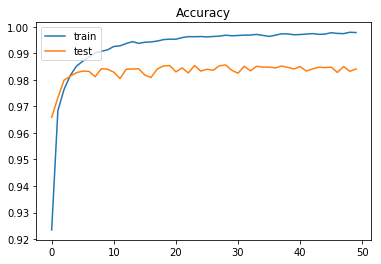

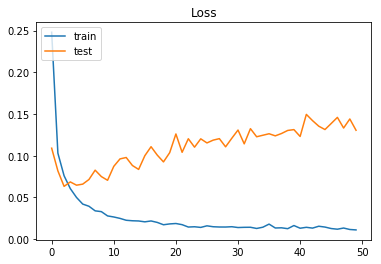

In [46]:
# MLPでMNISTの分類問題に挑戦
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.datasets import mnist
import matplotlib.pyplot as plt

# 入力と出力を指定
in_size = 28 * 28
out_size = 10

# MNISTのデータを読み込み --- (*1)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# データを28*28=784の一次元配列に変換
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255
# ラベルデータをone-hotベクトルに直す
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'),10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'),10)

# MLPモデル構造を定義 --- (*2)
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築 --- (*3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 学習を実行 --- (*4)
hist = model.fit(X_train, y_train,
          batch_size=128, 
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

# モデルを評価 --- (*5)
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

# 学習の様子をグラフへ描画 --- (*6)
# 正解率の推移をプロット
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.2313 - acc: 0.9306 - val_loss: 0.0491 - val_acc: 0.9835
Epoch 2/12
60000/60000 [==============================] - 4s 60us/step - loss: 0.0846 - acc: 0.9762 - val_loss: 0.0431 - val_acc: 0.9851
Epoch 3/12
60000/60000 [==============================] - 3s 58us/step - loss: 0.0626 - acc: 0.9817 - val_loss: 0.0348 - val_acc: 0.9891
Epoch 4/12
60000/60000 [==============================] - 4s 59us/step - loss: 0.0533 - acc: 0.9843 - val_loss: 0.0329 - val_acc: 0.9883
Epoch 5/12
60000/60000 [==============================] - 4s 59us/step - loss: 0.0479 - acc: 0.9857 - val_loss: 0.0375 - val_acc: 0.9884
Epoch 6/12
60000/60000 [==============================] - 4s 60us/step - loss: 0.0453 - acc: 0.9867 - val_loss: 0.0331 - val_acc: 0.9900
Epoch 7/12
60000/60000 [==============================] - 4s 59us/step - loss: 0.0440 - acc: 0.9878 - val_loss: 0.0310 - val_acc

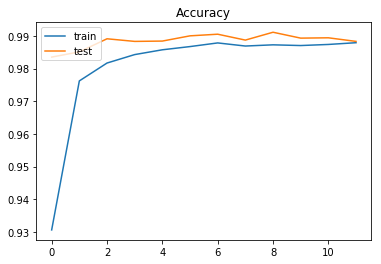

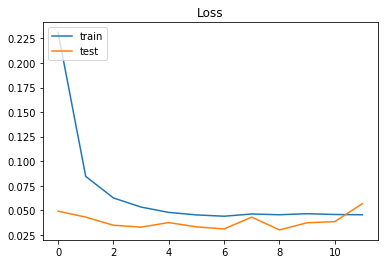

In [47]:
# CNNでMNISTの分類問題に挑戦
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
import matplotlib.pyplot as plt

# 入力と出力を指定
in_shape = (28, 28, 1)
out_size = 10


# MNISTのデータを読み込み 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# データを(1, 28, 28)の三次元配列に変換
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
# ラベルデータをone-hotベクトルに直す
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'),10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'),10)

# CNNモデル構造を定義 --- (*2)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=in_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築 --- (*3)
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# 学習を実行 --- (*4)
hist = model.fit(X_train, y_train,
          batch_size=128, 
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test))

# モデルを評価 --- (*5)
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

# 学習の様子をグラフへ描画 --- (*6)
# 正解率の推移をプロット
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# モデルを保存
model.save('MNIST_x1.5_60000_model.h5')
# 学習済み重みデータを保存
model.save_weights('MNIST_x1.5_60000_weight.h5')